# Dimension reduction of double-wedge dataset

Here we use the [double-wedge (or sqrt) model](../datasets/plot_sqrt_model.html) to compare some of the dimension reduction methods in a time-homogeneous setting.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from deeptime.data import sqrt_model

First we generate the training data with the binary classification according to wedge (`dtraj`) and two-dimensional state vectors (`sqrt`). Goal is to reconstruct `dtraj` from `traj`.

In [2]:
dtraj, traj = sqrt_model(n_samples=1000, seed=777)

We can define the back-transform to make the drawn trajectory frames linearly separable according to state:

In [3]:
def back_transform(x):
    y = np.copy(x)
    y[:, 1] = y[:, 1] - np.sqrt(np.abs(y[:, 0]))
    return y

The dataset is set up as follows: The discrete trajectory (upper left panel) has corresponding two-dimensional and linearly separable datapoints (upper right panel) which are subsequently transformed through a squareroot-like function to produce the double-wedge (lower left panel).

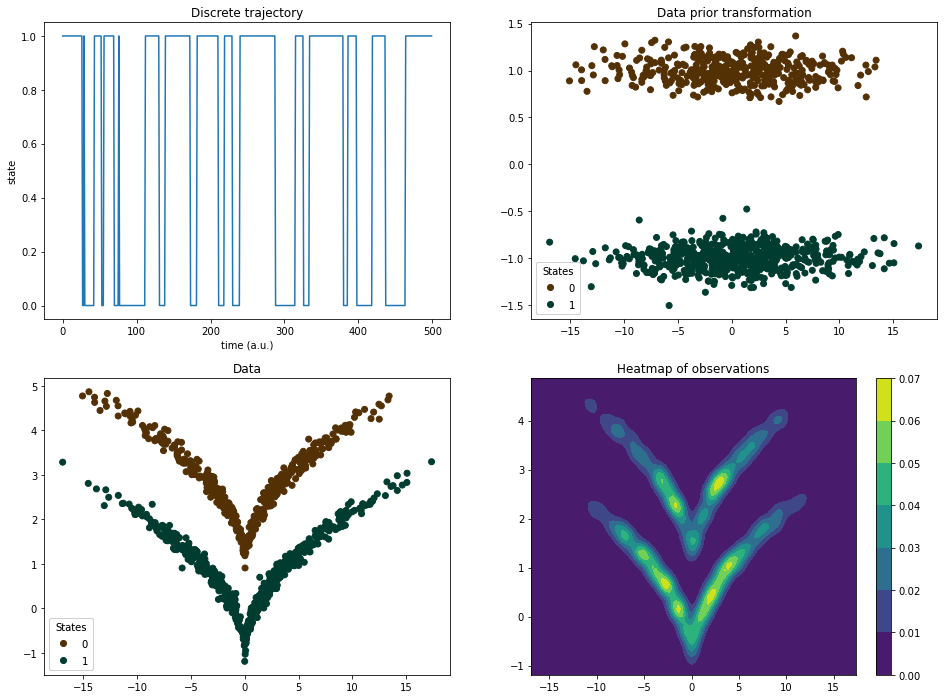

In [4]:
X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

import scipy.stats as stats
kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, axes = plt.subplots(2, 2, figsize=(16, 12))
ax1 = axes[0, 0]
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

ax2 = axes[0, 1]
ax2.set_title('Data prior transformation')
scatter = ax2.scatter(*back_transform(traj).T, c=dtraj, cmap='BrBG')
legend1 = ax2.legend(*scatter.legend_elements(), title="States", loc='lower left')
ax2.add_artist(legend1)

ax3 = axes[1, 0]
ax3.set_title('Data')
scatter = ax3.scatter(*traj.T, c=dtraj, cmap='BrBG')
legend1 = ax3.legend(*scatter.legend_elements(), title="States", loc='lower left')
ax3.add_artist(legend1)

ax4 = axes[1, 1]
cm = ax4.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax4);
ax4.set_title('Heatmap of observations');

Let us now compare the different methods. To this end we first define a plotting routine.

In [5]:
def plot_method(transform, score, score_std):
    r""" Plotting method for the different models.
    
    Parameters
    ----------
    transform : Callable
        Function pointer that projects data into a one-dimensional space.
    score
        VAMP-2 score
    score_std
        VAMP-2 score standard deviation
    """
    from deeptime.clustering import KMeans
    from matplotlib.colors import Normalize
    
    feat = transform(traj)
    feat_cc = KMeans(2).fit_transform(feat)
    
    xmax = np.max(np.abs(traj[:, 0]))
    ymin = np.min(traj[:, 1])
    ymax = np.max(traj[:, 1])
    vmin = np.min(feat)
    vmax = np.max(feat)
    vmag = np.max([np.abs(vmin), np.abs(vmax)])
    
    scatter_size = 35
    
    grid = np.meshgrid(np.linspace(-xmax-1, xmax+1, 500), np.linspace(ymin-1, ymax+1, 500))
    xy = np.dstack(grid).reshape(-1, 2)
    levels = np.linspace(0, vmag, num=5)
    
    z = np.concatenate([transform(xxyy) for xxyy in np.array_split(xy, 3)])
    z00 = transform(np.array([0, -1]).reshape(-1, 2))
    z = np.clip(z, vmin, vmax)
    
    if np.mean(np.abs((feat_cc[:500].squeeze() - dtraj[:500]))) > .3:
        feat_cc = 1. - feat_cc
    if z00 < 0:
        z *= -1.
    z *= -1
    
    cmap = 'BrBG'
    f = plt.figure(figsize=(6, 6), constrained_layout=True)
    height_ratios = [2, 1]
    gs = f.add_gridspec(2, 1, height_ratios=height_ratios)
    
    ax = f.add_subplot(gs[0, 0])
    
    norm = Normalize(-vmag, vmag)
    levels_fine = np.linspace(0, levels[1], num=5)
    levels = np.concatenate([-levels[2:][::-1], -levels_fine[1:][::-1], levels_fine, levels[2:]])
    
    cb = ax.contourf(grid[0], grid[1], z.reshape(grid[0].shape), levels=levels, 
                     cmap=cmap, norm=norm, extend='both')

    ticks = levels
    cb = f.colorbar(cb, ax=ax, ticks=ticks[1::3])
    cb.ax.set_yticklabels([f"{x:.2f}" for x in ticks[1::3]])
    
    ix_0 = np.where((feat_cc == 0) & (feat_cc == dtraj))[0]
    ix_1 = np.where((feat_cc == 1) & (feat_cc == dtraj))[0]
    
    ax.scatter(*traj[ix_0].T, 
               color=plt.cm.plasma(.3), 
               s=scatter_size, linewidths=.1,
               marker='o', cmap=cmap, edgecolors='black', 
               zorder=500, alpha=.5, label=f'Estimated state {0}')
    ax.scatter(*traj[ix_1].T, 
               color=plt.cm.plasma(.8), 
               s=scatter_size, linewidths=.1,
               marker='o', cmap=cmap, edgecolors='black', 
               zorder=500, alpha=.5, label=f'Estimated state {1}')
    
    ix_0 = np.where((feat_cc == 0) & (feat_cc != dtraj))[0]
    ix_1 = np.where((feat_cc == 1) & (feat_cc != dtraj))[0]
    
    if len(ix_0) > 0:
        ax.scatter(*traj[ix_0].T, 
                   color=plt.cm.plasma(.3),
                   s=scatter_size, linewidths=.5,
                   marker='o', cmap=cmap, edgecolors='red', 
                   zorder=500, alpha=.5)
    if len(ix_1) > 0:
        ax.scatter(*traj[ix_1].T, 
               color=plt.cm.plasma(.8), 
               s=scatter_size, linewidths=.5,
               marker='o', cmap=cmap, edgecolors='red', 
               zorder=500, alpha=.5)
    
    ax.legend()
    
    props = dict(boxstyle='square', facecolor='white', alpha=.8)
    ax.text(0.5, 0.08, r"$s={:.2f}\pm {:.2f}$".format(score, score_std), transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='center', bbox=props, fontsize='x-small')
    
    ax = f.add_subplot(gs[1, 0])
    n_proj = 200
    mismatch = 100. * float(np.count_nonzero(feat_cc - dtraj)) / float(len(dtraj))
    rescaled_proj = .5*(feat[:n_proj] + 1)
    feat_cc = feat_cc[:n_proj]
    if np.mean(np.abs((rescaled_proj.squeeze() - dtraj[:n_proj]))) > .4:
        rescaled_proj = 1. - rescaled_proj
    xs = np.arange(len(rescaled_proj))
    ax.plot(xs, rescaled_proj, alpha=.3, color='C0')
    ax.plot(xs, feat_cc, color='C0', label=r'Estimated (${:.1f}\%$ mismatch)'.format(mismatch))
    ax.plot(xs, dtraj[:n_proj], color='C1', linestyle='dotted', label='Ground truth')
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel(r'$\chi (x_t)$')
    ax.set_ylim([-.5, 1.5])
    ax.set_yticks([0, 1])
    ax.set_title(r"${:.1f}\%$ acc.".format(100-mismatch))
    ax.legend(loc="lower center", ncol=2)
    
    plt.show()

## TICA

We use the linear TICA method.

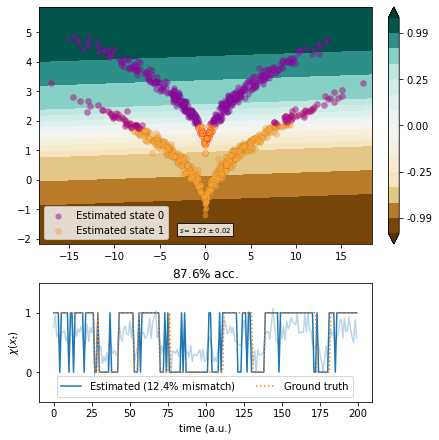

In [6]:
from deeptime.decomposition import vamp_score_cv
from deeptime.decomposition import TICA

estimator = TICA(lagtime=1, dim=1)
tica = estimator.fit_fetch(traj)
scores = vamp_score_cv(estimator, traj, lagtime=1, random_state=42)

plot_method(tica.transform, scores.mean(), scores.std())

## EDMD

We use EDMD with a polynomial ansatz basis of degree up to $2$.

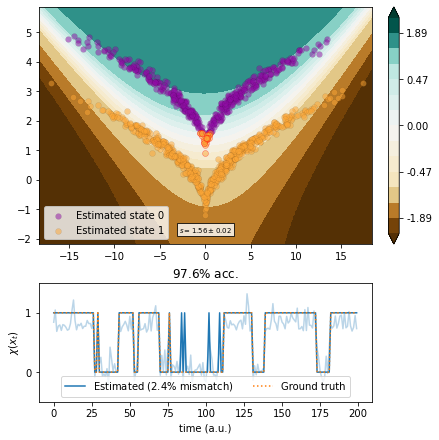

In [7]:
from deeptime.decomposition import EDMD, VAMP
from deeptime.basis import Monomials

basis = Monomials(p=2, d=2)
edmd = EDMD(basis=basis).fit_fetch(traj, lagtime=1)

vamp_edmd = VAMP(lagtime=1, dim=1, 
                 observable_transform=lambda x: edmd.transform(x).real)
scores = vamp_score_cv(vamp_edmd, traj, lagtime=1, random_state=42)

plot_method(lambda x: edmd.transform(x)[..., 1].real, scores.mean(), scores.std())

## VAMP with backtransform

We use VAMP with knowledge about the ground truth to make data linearly separable.

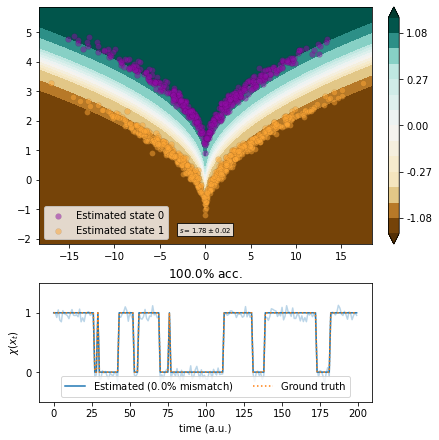

In [8]:
vamp_back = VAMP(lagtime=1, dim=1, 
                 observable_transform=back_transform).fit(traj)
scores = vamp_score_cv(vamp_back, traj, lagtime=1, random_state=42)
plot_method(vamp_back.transform, scores.mean(), scores.std())

## Kernel EDMD

We use kernel EDMD with a Gaussian kernel and parameter optimization in whitened space.

In [9]:
from deeptime.covariance import Covariance
cov = Covariance(lagtime=1, compute_c0t=True).fit(traj).fetch_model()
whitened_traj = cov.whiten(traj)

In [10]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

from deeptime.kernels import GaussianKernel
from deeptime.decomposition import KernelEDMD

def objective(params):
    bw, eps = params
    est = KernelEDMD(GaussianKernel(bw), n_eigs=2, epsilon=eps)
    kedmd = est.fit_fetch(whitened_traj, lagtime=1)
    kedmd_transf = lambda x: (kedmd.transform(cov.whiten(x)).real).reshape(-1, 2)
    vamp_kedmd = VAMP(lagtime=1, dim=1, epsilon=1e-16, 
                      observable_transform=kedmd_transf).fit_fetch(traj)
    return -vamp_kedmd.score(2)


bounds = Bounds([1e-2, 1e-6], [1e1, 1e-2])
result = minimize(objective, x0=[1.4, 1.6e-3], bounds=bounds, method='SLSQP')
bw, eps = result.x
print(f"Estimated bandwidth {bw:.3e} and regularization parameter {eps:.3e}.")

/srv/data/clonker/miniconda3/envs/deeptime/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Estimated bandwidth 1.376e+00 and regularization parameter 1.090e-06.


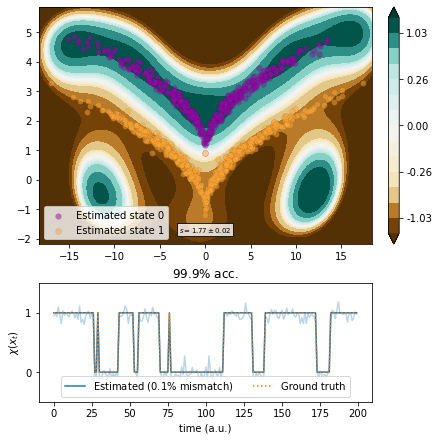

In [11]:
kernel = GaussianKernel(bw)
kedmd = KernelEDMD(kernel=kernel, epsilon=1e-3, n_eigs=2).fit_fetch(whitened_traj, lagtime=1)

kedmd_transf = lambda x: (kedmd.transform(cov.whiten(x)).real).reshape(-1, 2)
vamp_kedmd = VAMP(lagtime=1, dim=1, epsilon=1e-16, observable_transform=kedmd_transf).fit(traj)
scores = vamp_score_cv(vamp_kedmd, traj, lagtime=1, random_state=42)

plot_method(vamp_kedmd.transform, scores.mean(), scores.std())

## Kernel CCA

We use kernel CCA with optimized kernel parameters.

In [12]:
from deeptime.decomposition import KernelCCA

def objective(params):
    bw, eps = params
    kcca = KernelCCA(GaussianKernel(bw), 1, epsilon=eps).fit((traj[:-1], traj[1:])).fetch_model()
    vamp_kcca = VAMP(lagtime=1, dim=1, 
                 observable_transform=lambda x: kcca.transform(x).real).fit(traj).fetch_model()
    return -vamp_kcca.score(2)

bounds = Bounds([1e-2, 1e-2], [1e-0, 1e-0])
result = minimize(objective, x0=[.8, .3], bounds=bounds, method='SLSQP')
bw, eps = result.x
print(f"Estimated bandwidth {bw:.3e} and regularization parameter {eps:.3e}.")

Estimated bandwidth 8.467e-01 and regularization parameter 1.000e-02.


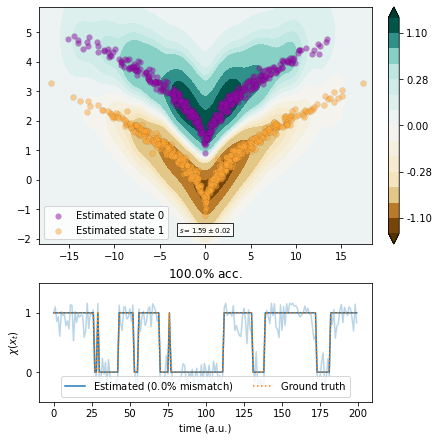

In [13]:
kernel = GaussianKernel(bw)
kcca = KernelCCA(kernel, 1, epsilon=eps).fit_fetch(traj, lagtime=1)

kcca_transform = lambda x: kcca.transform(x).real
vamp_kcca = VAMP(lagtime=1, dim=1, observable_transform=kcca_transform).fit(traj)
scores = vamp_score_cv(vamp_kcca, traj, lagtime=1, random_state=42)

plot_method(vamp_kcca.transform, scores.mean(), scores.std())

## VAMPNets

We use VAMPNets with a multilayer preceptron (MLP) architecture.

In [14]:
import torch.nn as nn
from torch.utils.data import DataLoader

from deeptime.util.data import TrajectoryDataset
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import VAMPNet

dataset = TrajectoryDataset(1, traj.astype(np.float32))
estimator = VAMPNet(lobe=MLP(units=[traj.shape[1], 15, 10, 10, 5, 1], nonlinearity=nn.ReLU), 
                    learning_rate=1e-3)
loader_train = DataLoader(dataset, batch_size=128, shuffle=True)
vampnet = estimator.fit_fetch(loader_train, n_epochs=170)

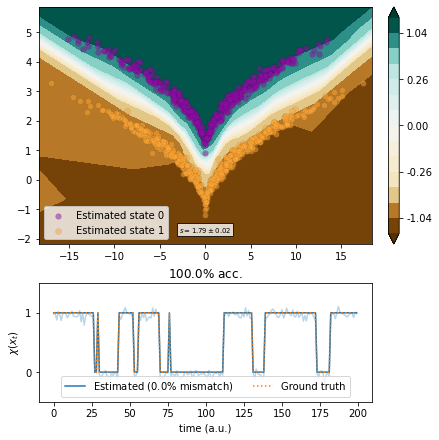

In [15]:
vamp_vampnet = VAMP(lagtime=1, dim=1, observable_transform=vampnet).fit(traj)
scores = vamp_score_cv(vamp_vampnet, traj, lagtime=1, random_state=42)

plot_method(vamp_vampnet.transform, scores.mean(), scores.std())